<a href="https://colab.research.google.com/github/rfdornelles/mds_ML_project/blob/main/scenarios_plot_xgboost_karon2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/rfdornelles/mds_ML_project/main/data/karon2.csv")

In [24]:
df.head()

,year,country,temp,population,qnt_death_heat_cold_exposure,temp_diff
0,1991,Albania,6.219891,3266790,5,0.050951
1,1992,Albania,6.284930,3247039,5,0.065040
2,1993,Albania,6.324316,3227287,5,0.039385
3,1994,Albania,6.357706,3207536,5,0.033390
4,1995,Albania,6.402805,3187784,6,0.045099


In [25]:
X = df.drop(["qnt_death_heat_cold_exposure", "country", "temp_diff"], axis = 1).to_numpy()
y = df["qnt_death_heat_cold_exposure"].to_numpy()

In [26]:
#https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn/notebook 

In [27]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score

import xgboost as xgb

In [28]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [29]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [30]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)

mse=mean_squared_error(y, y_pred)

print(np.sqrt(mse))
print("R2:", r2_score(y, y_pred))

67.34764630310802
R2: 0.9861534867247158


In [31]:
xgb_model

XGBRegressor(objective='reg:squarederror', random_state=42)

In [32]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)

scores = []

In [33]:
for train_index, test_index in kfold.split(X):   
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb_model = xgb.XGBRegressor(objective="reg:squarederror")
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_test)
    
    scores.append(mean_squared_error(y_test, y_pred))
    
display_scores(np.sqrt(scores))
print("R2:", r2_score(y_test, y_pred))

Scores: [102.90442912  86.73481857  97.15700031 117.28103054 122.66048715]
Mean: 105.348
Std: 13.127
R2: 0.9437446154139051


In [34]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

scores = cross_val_score(xgb_model, X, y, scoring="neg_mean_squared_error", cv=5)

display_scores(np.sqrt(-scores))

Scores: [ 256.57654267 1071.80656933  173.99060636  128.40856853 1207.45216773]
Mean: 567.647
Std: 470.784


In [35]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X, y)

report_best_scores(search.cv_results_, 1)


Fitting 3 folds for each of 200 candidates, totalling 600 fits
Model with rank: 1
Mean validation score: -0.562 (std: 0.735)
Parameters: {'colsample_bytree': 0.9040922615763338, 'gamma': 0.2252496259847715, 'learning_rate': 0.033979488347959955, 'max_depth': 2, 'n_estimators': 113, 'subsample': 0.9233589392465844}



In [36]:
mse = mean_squared_error(y_test, search.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 51675.1158


In [37]:
#print("coef:", pipe['model'].coef_)
#print("intercept:", pipe['model'].intercept_)
print("R2:", r2_score(y_test, search.predict(X_test)))

R2: 0.8067870699472148


In [38]:
best_params = {'colsample_bytree': 0.9040922615763338, 'gamma': 0.2252496259847715, 'learning_rate': 0.033979488347959955, 'max_depth': 2, 'n_estimators': 113, 'subsample': 0.9233589392465844}

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", 
                             random_state=42, 
                             params = best_params)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mse=mean_squared_error(y_test, y_pred)

print(np.sqrt(mse))
print("R2:", r2_score(y_test, y_pred))



122.66048714938465
R2: 0.9437446154139051


In [39]:
# Predictions

df_rcp45 = pd.read_csv("https://github.com/rfdornelles/mds_ML_project/raw/main/data/pred_y_2022_2050_rcp45.csv")

X_rcp45 = df_rcp45[df_rcp45["country"] == "Germany"].drop(["country"],axis = 1)

In [40]:
y_rcp45 = xgb_model.predict(X_rcp45.to_numpy())

In [41]:
X_rcp45["pred_rcp45"] = y_rcp45.round()

In [42]:
print(X_rcp45)

     year      temp  population  pred_rcp45
319  2022  6.990748    83001000       164.0
320  2023  7.030051    82837000       164.0
321  2024  7.060947    82678000       164.0
322  2025  7.105634    82553000       164.0
323  2026  7.138498    82460000       164.0
324  2027  7.167267    82390000       164.0
325  2028  7.177644    82333000       164.0
326  2029  7.200059    82276000       164.0
327  2030  7.215023    82210000       164.0
328  2031  7.242563    82133000       164.0
329  2032  7.249095    82045000       164.0
330  2033  7.249983    81947000       164.0
331  2034  7.290183    81839000       164.0
332  2035  7.308158    81720000       164.0
333  2036  7.356454    81591000       164.0
334  2037  7.373711    81450000       164.0
335  2038  7.384128    81295000       164.0
336  2039  7.418958    81128000       164.0
337  2040  7.440450    80946000       164.0
338  2041  7.477238    80751000       164.0
339  2042  7.501888    80543000       161.0
340  2043  7.540251    80322000 

RCP 85

In [43]:
# Predictions

df_rcp85 = pd.read_csv("https://github.com/rfdornelles/mds_ML_project/raw/main/data/pred_y_2022_2050_rcp85.csv")

X_rcp85 = df_rcp85[df_rcp85["country"] == "Germany"].drop(["country"],axis = 1)

In [44]:
y_rcp85 = xgb_model.predict(X_rcp85.to_numpy())

In [45]:
X_rcp85["pred_rcp85"] = y_rcp85.round()

In [46]:
print(X_rcp85)

     year      temp  population  pred_rcp85
348  2022  7.112327    83001000       164.0
349  2023  7.139563    82837000       164.0
350  2024  7.171224    82678000       164.0
351  2025  7.221347    82553000       164.0
352  2026  7.255625    82460000       164.0
353  2027  7.270194    82390000       164.0
354  2028  7.305102    82333000       164.0
355  2029  7.326372    82276000       164.0
356  2030  7.330444    82210000       164.0
357  2031  7.347063    82133000       164.0
358  2032  7.386325    82045000       164.0
359  2033  7.404685    81947000       164.0
360  2034  7.405402    81839000       164.0
361  2035  7.426229    81720000       164.0
362  2036  7.467698    81591000       164.0
363  2037  7.517649    81450000       164.0
364  2038  7.553091    81295000       164.0
365  2039  7.591253    81128000       164.0
366  2040  7.639999    80946000       164.0
367  2041  7.706964    80751000       164.0
368  2042  7.757775    80543000       161.0
369  2043  7.814471    80322000 

In [47]:
plot_df = pd.DataFrame()
plot_df["year"] = range(1991, 2051)

In [48]:
df_actual_values = df[df["country"] == "Germany"][["year", "qnt_death_heat_cold_exposure"]]

In [49]:
df_rcp85 = X_rcp85[["year", "pred_rcp85"]]

In [50]:
df_rcp45 = X_rcp45[["year", "pred_rcp45"]]

In [51]:
plot_df = plot_df.merge(df_actual_values, on = "year", how = "left")

plot_df = plot_df.merge(df_rcp45, on = "year", how = "left")

plot_df = plot_df.merge(df_rcp85, on = "year", how = "left")

plot_df

,year,qnt_death_heat_cold_exposure,pred_rcp45,pred_rcp85
0,1991,204.0,NaN,NaN
1,1992,204.0,NaN,NaN
2,1993,211.0,NaN,NaN
3,1994,211.0,NaN,NaN
4,1995,225.0,NaN,NaN
5,1996,232.0,NaN,NaN
6,1997,221.0,NaN,NaN
7,1998,202.0,NaN,NaN
8,1999,185.0,NaN,NaN
9,2000,179.0,NaN,NaN


ValueError: ignored

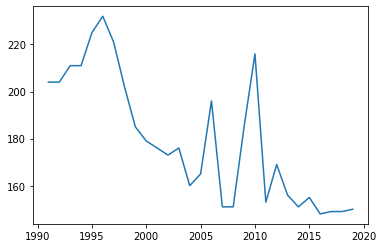

In [54]:
# importing package
import matplotlib.pyplot as plt

# plot lines

plt.plot(df_actual_values["year"], df_actual_values["qnt_death_heat_cold_exposure"], label = "line 1")
plt.plot(df_rcp45["year"], df_rcp45["pred_rcp45"], label = "line 3", )
plt.plot(df_rcp85["year"], df_rcp85["pred_rcp85"], label = "line 2")
plt.legend()
plt.show()
